Questions & commentaires

- Est ce que les désignations et descriptions sont toutes en français ?
- Faut il fusionner X_train (features) avec Y_train (variables cible) ? Ou on passe les 2 au modèle pour entraînement et il se débrouille ?
- Quels pré traitements peut on faire sur les images dans le cadre du preprocessing ?
- Comment peut on nettoyer le jeu d'images ?
- Que faire des descriptions vides ? De celles qui sont quasiment dupliquées ? De celles qui ne veulent rien dire (balise html) etc.
- Que faire de la colonne Unnamed ? Faut il read le csv avec index_col = 0 ?
- L'id des lignes dans X_train permet t-il de faire le rapprochement avec les id dans prdtypecode ? (y_train)
- l'imageId correspond à quoi exactement dans x train
- Comment faire le rapprochement entre les images et les descriptions ? (id dans x_train et id dans y_train)

In [3]:
# import des libraires importantes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# chargement des fichiers

X_train = pd.read_csv('../data/X_train_update.csv')

#lecture premières lignes

X_train.head()

#description et info basiques

X_train.describe()
X_train.info()

# affichage des colonnes

X_train.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB


Index(['Unnamed: 0', 'designation', 'description', 'productid', 'imageid'], dtype='object')

In [4]:
# que faire de la colonne unnamed : 0 ?
# on peut la supprimer car elle ne contient pas d'information utile

X_train = X_train.drop(columns=['Unnamed: 0'])



In [8]:
#check des valeurs manquantes
X_train.isnull().sum()


designation        0
description    29800
productid          0
imageid            0
dtype: int64

In [ ]:
#seules les descriptions ont des valeurs manquantes


In [ ]:
#analysons en profondeur chaque variable pour en retirer le maximum d'informations
#et enrichir notre dataset

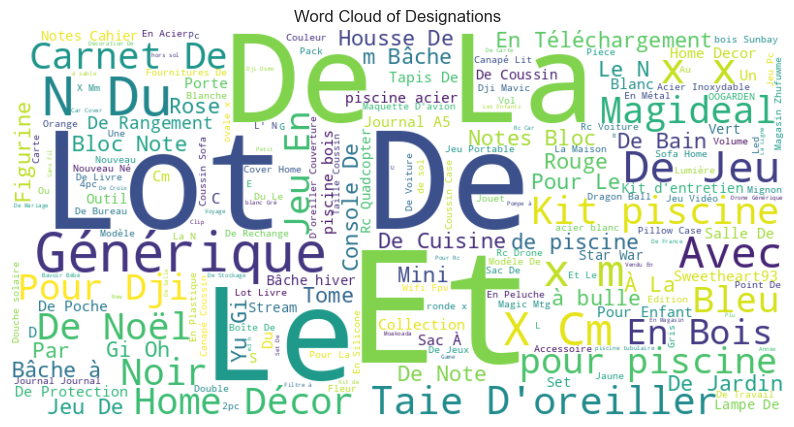

In [9]:
#traitement de la variable designation correspondant au titre du produit

#on peut faire un wordcloud pour visualiser les mots les plus fréquents dans les titres
plt.figure(figsize=(10, 6))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(X_train['designation'].dropna()))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Designations')
plt.show()



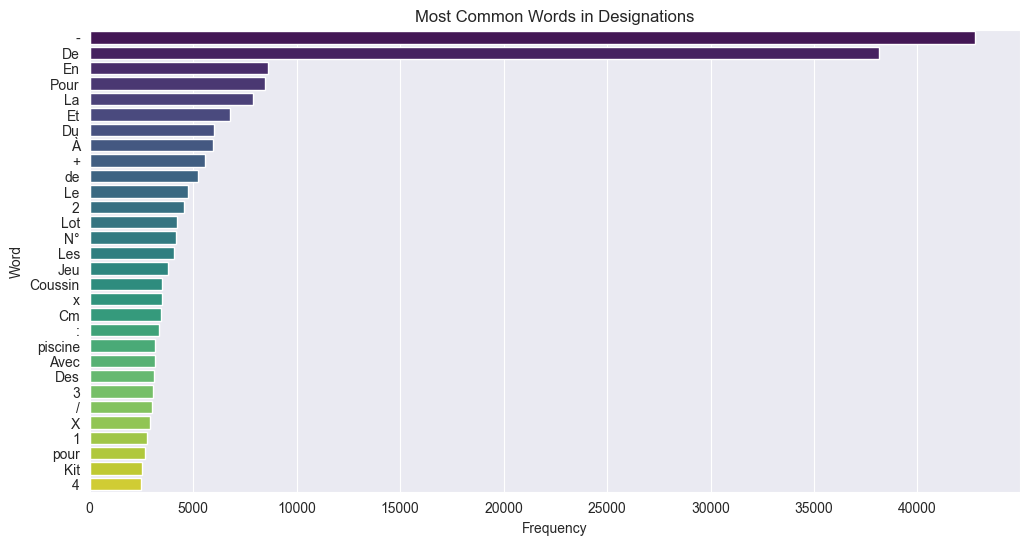

In [5]:
# Il faut trouver un moyen de mettre en avant de l'information pertinent sur les désignations

# On peut par exemple extraire les mots les plus fréquents
from collections import Counter
def get_most_common_words(series, n=10):
    words = ' '.join(series.dropna()).split()
    most_common = Counter(words).most_common(n)
    return most_common

most_common_words = get_most_common_words(X_train['designation'], n=30)
# Convert to DataFrame for better visualization
most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=most_common_df, palette='viridis', hue='Word')
plt.title('Most Common Words in Designations')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


In [6]:
#1. on remarque qu'on est très pollué par des tirets
#2. Les mots les plus fréquents sont des mots de liaison du type "de, en, pour, la, et..."

# On peut nettoyer cette variable pour en retirer toute l'information pertinente
#attention aux apostrophes qui créent des mots bizarres : d'art doit devenir art et non dart
#si une lettre est suivie d'une apostrophe, enlever la lettre et l'apostrophe

def clean_apostrophe_words(designation):
    # Convert to lowercase
    designation = designation.lower()
    # Split the text into words
    words = designation.split()
    # Process each word
    cleaned_words = []
    for word in words:
        if "'" in word:
            # Keep only the part after the apostrophe
            cleaned_words.append(word.split("'")[1])
        else:
            cleaned_words.append(word)
    # Join the cleaned words back into a string
    return ' '.join(cleaned_words)

# Apply the function to the 'designation' column
X_train['cleaned_designation'] = X_train['designation'].apply(clean_apostrophe_words)

# Display the cleaned designations
X_train[['designation', 'cleaned_designation']].head()



,designation,cleaned_designation
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,olivia: personalisiertes notizbuch / 150 seite...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,journal des arts (le) n° 133 du 28/09/2001 - a...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,grand stylet ergonomique bleu gamepad nintendo...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,peluche donald - europe - disneyland 2000 (mar...
4,La Guerre Des Tuques,la guerre des tuques


In [7]:
# il faut réflechir à comment la désignation va être utile pour classer le produit dans
#le bon prdtypecode

# On peut par exemple extraire les mots clés de la désignation
# en ce sens, il faut faire attention car il s'agit de produits e-commerce
# dans les titres des produits on a donc parfois les mots comme "lot", "kit" etc.
# on a parfois des mots comme N°
# les titres avec des apostrophes qui pourraient donner des mots faussés si mal traités exemple : "d'art" qui donne "dart"
# Il faut donc extraire les mots clés pertinents pour la classification

def extract_keywords(designation):
    # Convert to lowercase
    designation = designation.lower()
    # Remove punctuation and special characters except apostrophes
    designation = ''.join(char for char in designation if char.isalnum() or char.isspace() or char == "'")
    # Remove extra spaces
    designation = ' '.join(designation.split())
    # let's remove the numbers to keep only the words
    designation = ''.join(char for char in designation if not char.isdigit())
    #let's remove a word when it is too short (1 or 2 characters)
    designation = ' '.join(word for word in designation.split() if len(word) > 2)
    # Split into words
    words = designation.split()
    # Remove common words (stop words) that are not useful for classification
    stop_words = {'de', 'en', 'pour', 'la', 'et', 'le', 'du', 'des', 'un', 'une', 'à', 'dans', 'avec', "/", 'n°', 'kit', 'lot', 'set', 'pack'}
    keywords = [word for word in words if word not in stop_words]
    return ' '.join(keywords)

# Appliquer la fonction d'extraction de mots clés

X_train['keywords'] = X_train['cleaned_designation'].apply(extract_keywords)
# Afficher les premières lignes pour vérifier l'extraction des mots clés
X_train[['cleaned_designation', 'keywords']].head()



,cleaned_designation,keywords
0,olivia: personalisiertes notizbuch / 150 seite...,olivia personalisiertes notizbuch seiten punkt...
1,journal des arts (le) n° 133 du 28/09/2001 - a...,journal arts art son marche salon art asiatiqu...
2,grand stylet ergonomique bleu gamepad nintendo...,grand stylet ergonomique bleu gamepad nintendo...
3,peluche donald - europe - disneyland 2000 (mar...,peluche donald europe disneyland marionnette d...
4,la guerre des tuques,guerre tuques


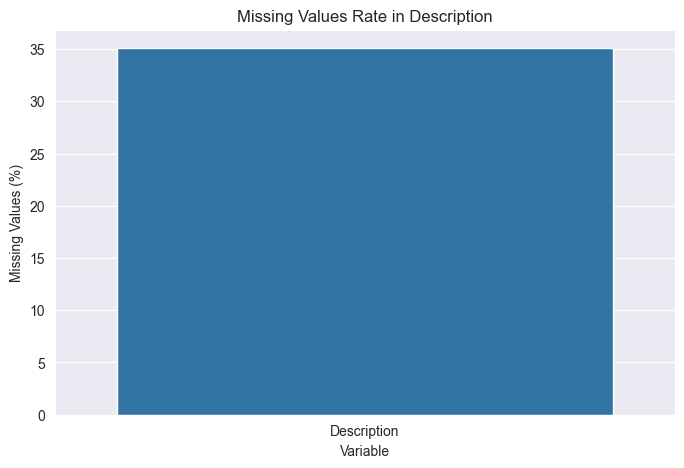

In [8]:
#maintenant passons à la deuxième variable
#traitement de la variable description
#d'abord faire quelques graphiques pour se rendre compte de quoi on parle

#taux de valeurs manquantes

missing_description_rate = X_train['description'].isnull().mean() * 100
plt.figure(figsize=(8, 5))
sns.barplot(x=['Description'], y=[missing_description_rate])
plt.title('Missing Values Rate in Description')
plt.ylabel('Missing Values (%)')
plt.xlabel('Variable')
plt.show()




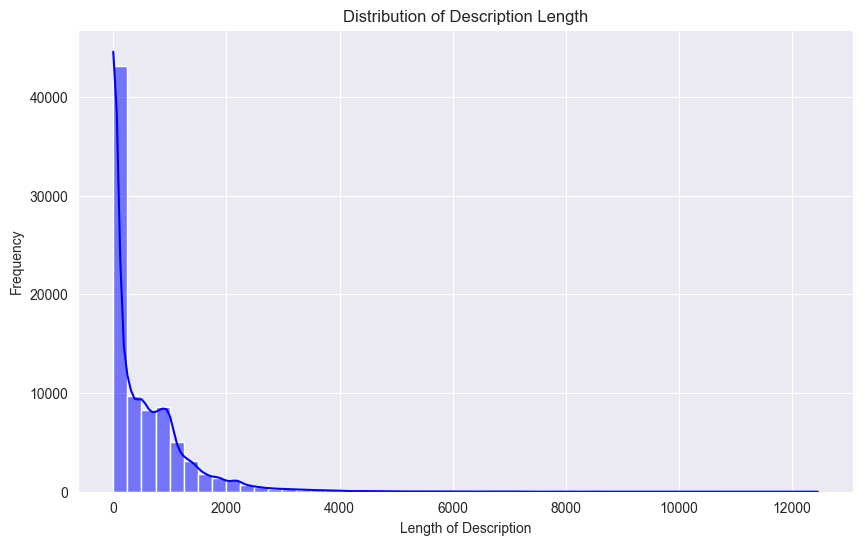

In [9]:
# Distribution de la longueur des descriptions
plt.figure(figsize=(10, 6))
X_train['description_length'] = X_train['description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
sns.histplot(X_train['description_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Description Length')
plt.xlabel('Length of Description')
plt.ylabel('Frequency')
plt.show()


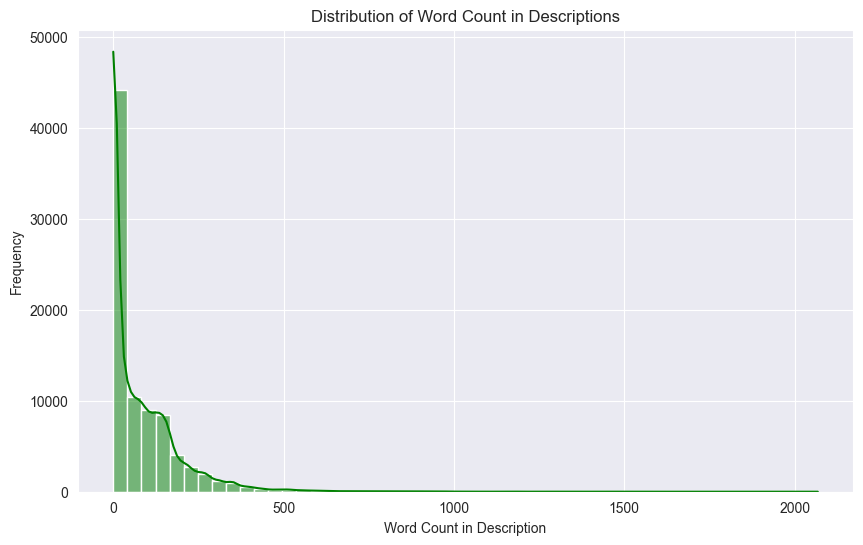

In [10]:
# Distribution des mots dans les descriptions
plt.figure(figsize=(10, 6))
X_train['description_word_count'] = X_train['description'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
sns.histplot(X_train['description_word_count'], bins=50, kde=True, color='green')
plt.title('Distribution of Word Count in Descriptions')
plt.xlabel('Word Count in Description')
plt.ylabel('Frequency')
plt.show()


In [11]:
#regardons à quoi ressemblent les 20 premières valeurs uniques des descriptions inférieures à 20 caractères
short_descriptions = X_train[X_train['description_length'] < 20]['description'].unique()[:20]
print("Short Descriptions (length < 20 characters):")
for desc in short_descriptions:
    print(f"- {desc}")

Short Descriptions (length < 20 characters):
- nan
- 50PV.
- <br />
- hauteur 12 cms
- peluche nounours
- ft 60 x 90 cm
- Dents forgées
- 1989
- Piano -
- BOARD GAME
- Chambre enfant
- ...
- Hauteur: 5 cm env.
- version francaise
- Set Superfun
- Snack volaille
- Hauteur: 20cm 
- Ref: 18500502.<br/>
- promo
- Type : Cartouche 


In [12]:
#supprimons toute trace de HTML et faisons un nettoyage sur les mots ou caractères qui créent
#du bruit type caractères spéciaux, tirets etc.

#appliquons simplement les mêmes traitements que pour la désignation

#il y a des choses bizarres du type : Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...

#corriger également les trucs comme  id&eacute;es ou &ecirc;tre

#cleaning des apostrophes
def clean_apostrophe_words(designation):
    # Convert to lowercase
    designation = designation.lower()
    # Split the text into words
    words = designation.split()
    # Process each word
    cleaned_words = []
    for word in words:
        if "'" in word:
            # Keep only the part after the apostrophe
            cleaned_words.append(word.split("'")[1])
        else:
            cleaned_words.append(word)
    # Join the cleaned words back into a string
    return ' '.join(cleaned_words)

def clean_description(description):
    if pd.isnull(description):
        return ''
    # Convert to lowercase
    description = description.lower()
    # Replace HTML entities with their corresponding characters
    description = description.replace('&eacute;', 'e').replace('&ecirc;', 'e').replace('&agrave;', 'a').replace('&ccedil;', 'c').replace('&nbsp;', ' ')
    # Remove HTML tags
    description = ' '.join(description.split())
    # Remove punctuation and special characters except apostrophes
    description = ''.join(char for char in description if char.isalnum() or char.isspace() or char == "'")
    # Remove extra spaces
    description = ' '.join(description.split())
    # let's remove the numbers to keep only the words
    description = ''.join(char for char in description if not char.isdigit())
    #let's remove a word when it is too short (1 or 2 characters)
    description = ' '.join(word for word in description.split() if len(word) > 2)
    #supprimer les accents et mettre la lettre correspondante
    description = description.replace('é', 'e').replace('è', 'e').replace('ê', 'e').replace('à', 'a').replace('ç', 'c')
    #clean des apostrophes avec la fonction
    description = clean_apostrophe_words(description)
    return description

# Appliquer la fonction de nettoyage à la colonne 'description'
X_train['cleaned_description'] = X_train['description'].apply(clean_description)
# Afficher les premières lignes pour vérifier le nettoyage des descriptions
X_train[['description', 'cleaned_description']].head(20)

,description,cleaned_description
0,NaN,
1,NaN,
2,PILOT STYLE Touch Pen de marque Speedlink est ...,pilot style touch pen marque speedlink est sty...
3,NaN,
4,Luc a des id&eacute;es de grandeur. Il veut or...,luc des idees grandeur veut organiser jeu guer...
5,NaN,
6,NaN,
7,CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...,conquerant classique cahier seyes incolorecouv...
8,NaN,
9,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...,tente pliante pro pvc grm mque vous soyez part...


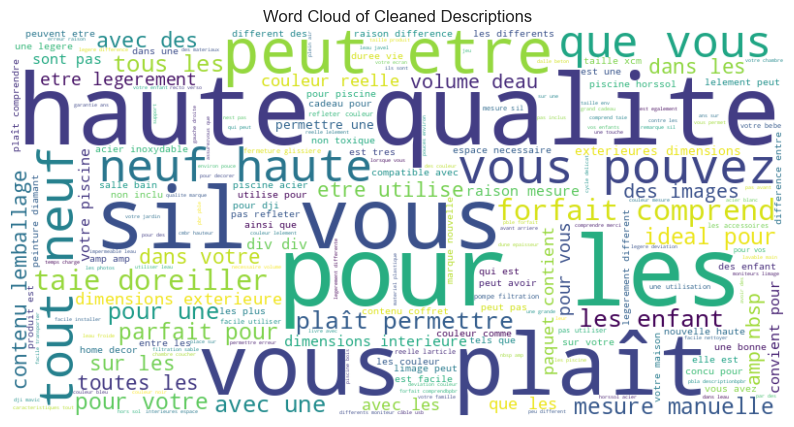

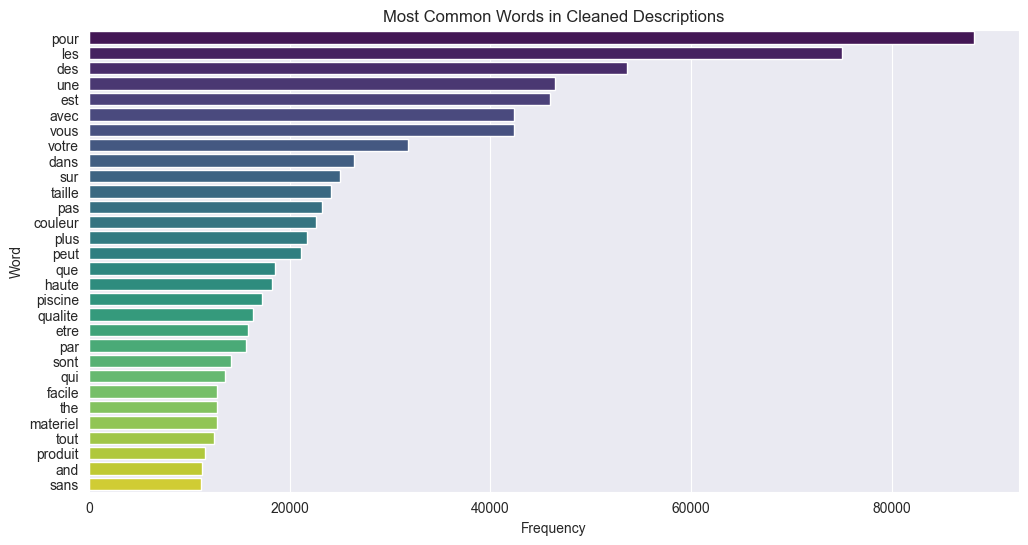

In [13]:
#après ce premier nettoyage, regardons ce que les descriptions nettoyées peuvent nous dire de supplémentaire

# On peut faire un wordcloud pour visualiser les mots les plus fréquents dans les descriptions nettoyées
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(X_train['cleaned_description'].dropna()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Descriptions')
plt.show()


#faisons également état des valeurs uniques les plus présentes
def get_most_common_words(series, n=10):
    words = ' '.join(series.dropna()).split()
    most_common = Counter(words).most_common(n)
    return most_common
most_common_words = get_most_common_words(X_train['cleaned_description'], n=30)
# Convert to DataFrame for better visualization
most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=most_common_df, palette='viridis', hue='Word')
plt.title('Most Common Words in Cleaned Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


In [44]:
#supprimons tout ce qui n'est pas un nom dans la langue française
#il faut trouver un moyen efficace de dépolluer les pronoms, verbes, etc.
#on doit faire ressortir les mots clés comme piscine, matériel, etc.

# / ! \ attention cette cellule a requis 15minutes sur mon ordinateur / ! \

# Il faut quelque chose d'automatique et pas une liste qu'on spécifie ce serait trop long
# Il faut aussi tenir compte des noms en français qui donnent parfois des verbes comme le mot : tente

# On peut utiliser un modèle de traitement du langage naturel (NLP) pour identifier les parties du discours (POS tagging)
import spacy

#need to install the module first with "python -m spacy download fr_core_news_sm"

# Charger le modèle français de spaCy
nlp = spacy.load("fr_core_news_sm")

# Fonction pour extraire les noms à partir d'une description
def extract_nouns(description):
    if pd.isnull(description):
        return ''
    doc = nlp(description)
    # Extraire les noms (nouns) et les adjectifs
    nouns = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]
    return ' '.join(nouns)
# Appliquer la fonction d'extraction des noms à la colonne 'cleaned_description'
X_train['nouns_description'] = X_train['cleaned_description'].apply(extract_nouns)
# Afficher les premières lignes pour vérifier l'extraction des noms
X_train[['cleaned_description', 'nouns_description']].head(20)




,cleaned_description,nouns_description
0,,
1,,
2,pilot style touch pen marque speedlink est sty...,touch pen speedlink stylet ergonomique gamepad...
3,,
4,luc des idees grandeur veut organiser jeu guer...,luc idees grandeur jeu guerre boules neige vai...
5,,
6,,
7,conquerant classique cahier seyes incolorecouv...,classique seyes incolorecouverture polypro pages
8,,
9,tente pliante pro pvc grm mque vous soyez part...,pliante pro pvc particulier jardin professionn...


In [14]:
from langdetect import detect
# il faudrait utiliser les 3 premiers mots de chaque description
# pour éviter de mapper l'ensemble qui prend trop de puissance

from langdetect import DetectorFactory
DetectorFactory.seed = 0  # For reproducibility
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

#créer une colonne échantillon contenant les 3 premiers mots de la description
X_train['sample_description'] = X_train['cleaned_description'].apply(lambda x: ' '.join(str(x).split()[:3]) if pd.notnull(x) else '')

# Appliquer la fonction de détection de langue
X_train['language'] = X_train['sample_description'].apply(detect_language)
# Afficher les langues détectées
language_counts = X_train['language'].value_counts()



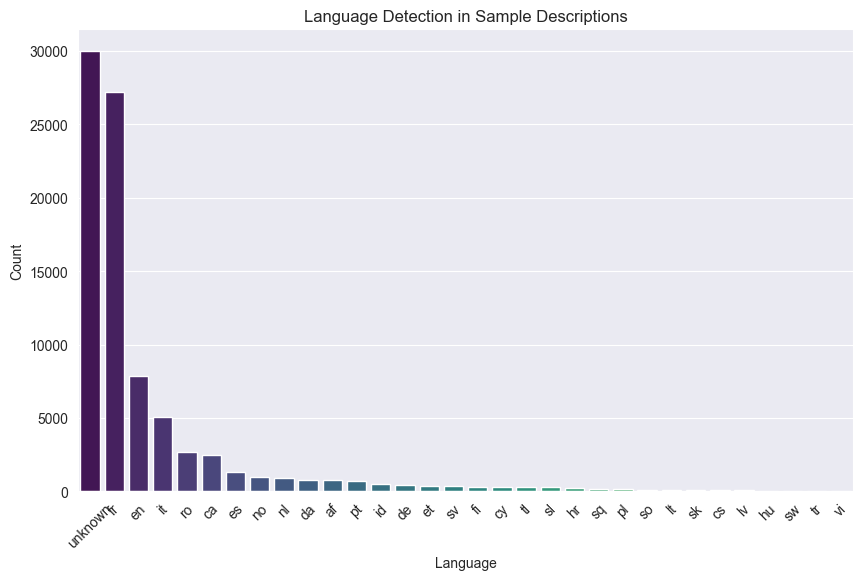

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts.index, y=language_counts.values, hue=language_counts.index, dodge=False, palette='viridis', legend=False)
plt.title('Language Detection in Sample Descriptions')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [37]:
#afficher les premières lignes des values qui sont unknown pour la détection du langage

unknown_descriptions = X_train[X_train['language'] == 'unknown']['cleaned_description'].head(20)
print("Unknown Language Descriptions:")
for desc in unknown_descriptions:
    print(f"{desc}")

#descriptions vides = langage inconnu

print(X_train[X_train['language'] == 'en'].head(20))


Unknown Language Descriptions:




















                                           designation  \
10               Eames Inspired Sxw Chair  Pink  Black   
12   Peaceable Kingdom Wheres Bear The Hide And Fin...   
33   Lindner 23652115ce Coin Case Nera Xl With 3 Tr...   
35   Decoration De Noel Christmas Snowman Kitchen T...   
39                 Boue gonflable River tube  OOGARDEN   
55   MoakoadaAbs Conglateur Teether Sensorielle Jou...   
67   Happy Halloween Sorcire Accueil Stickers Murau...   
76   60ml Halloween Head Ghost Mlange Nuage Slime P...   
81   Maquette Davion Protective Silicone Cover Case...   
84       Bche hiver pour piscine Toledo  280 grm  Bleu   
88                Hello Kitty Ugly Doll Ox  7 In Plush   
95   Magasin ZhufuwmeEnglish Alphabet Coussin Impri...   
114  Jouet Halloween Horror Grimace Night Terror Ma...   
121  Motif De Tapisserie De Mode Style Frais Tapiss...   
133  Bontempi Casa Table Avec Structure Anthracite ...   
185             Littl

In [23]:
#En fouillant un peu on se rend compte qu'il y a des mélanges dans les langues avec du français, de l'anglais etc.
# à voir ce qu'on décide de faire avec cette information

#par exemple on peut avoir une description du type : bouée gonflable river tube interprété comme de l'anglais alors que c'est un item fr


In [40]:
# on passe a productid
#on étudie la variable

# regardons s'il y a des duppliqués

duplicates = X_train[X_train.duplicated(subset=['productid'], keep=False)]
print("Duplicate Product IDs:")
print(duplicates[['productid', 'designation']].head(20))

#pas de duppliqués


Duplicate Product IDs:
Empty DataFrame
Columns: [productid, designation]
Index: []


In [41]:
# nombre de valeurs uniques

unique_product_ids = X_train['productid'].nunique()
print(f"Number of unique product IDs: {unique_product_ids}")


Number of unique product IDs: 84916


In [ ]:
# vu que c'est un id, on ne peut pas faire grand chose de plus

In [44]:
#imageid

# on peut regarder les valeurs uniques
unique_image_ids = X_train['imageid'].nunique()
print(f"Number of unique image IDs: {unique_image_ids}")

# on peut regarder les 20 premières valeurs uniques
unique_image_ids_sample = X_train['imageid'].unique()[:20]
print("Sample of unique image IDs:")
for image_id in unique_image_ids_sample:
    print(image_id)

Number of unique image IDs: 84916
Sample of unique image IDs:
1263597046
1008141237
938777978
457047496
1077757786
393356830
907794536
999581347
1325918866
1245644185
1111840281
1295816984
1204199842
1109088140
1292441752
1237257586
1239242410
1156191369
857195931
1027257229


In [45]:
#import de Y_train_CVw08PX.csv pour faire le rapprochement avec X_train

Y_train = pd.read_csv('../data/Y_train_CVw08PX.csv')

# affichage des premières lignes
Y_train.head()

# description et info basiques
Y_train.describe()
Y_train.info()

# affichage des colonnes
print("Y_train columns:", Y_train.columns)

# vérification des valeurs manquantes
missing_values_y = Y_train.isnull().sum()

print("Missing values in Y_train:")
print(missing_values_y)

# vérification des valeurs uniques dans prdtypecode
unique_prdtypecodes = Y_train['prdtypecode'].nunique()
print(f"Number of unique prdtypecodes: {unique_prdtypecodes}")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Unnamed: 0   84916 non-null  int64
 1   prdtypecode  84916 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB
Y_train columns: Index(['Unnamed: 0', 'prdtypecode'], dtype='object')
Missing values in Y_train:
Unnamed: 0     0
prdtypecode    0
dtype: int64
Number of unique prdtypecodes: 27


* 27 catégories uniques
* Nombre de lignes correspondant au nombre de lignes dans X_train donc ça a l'air de bien correspondre les 2



In [46]:
# étude des images

# semblent être sous le format : image_{imageid}_product_{productid}.jpg

# on peut vérifier si les images existent dans le dossier ../data/images

import os

image_folder = "../data/images/images/image_train"
missing_images = []
for index, row in X_train.iterrows():
    image_id = row['imageid']
    product_id = row['productid']
    image_filename = f"image_{image_id}_product_{product_id}.jpg"
    image_path = os.path.join(image_folder, image_filename)
    if not os.path.exists(image_path):
        missing_images.append(image_filename)
if missing_images:
    print(f"Missing images: {len(missing_images)}")
    print("Sample of missing images:", missing_images[:10])
else:
    print("All images are present.")


# tous les produits semblent avoir une image qui leur correspond

All images are present.


In [47]:
#réalisons tous les traitements possibles rendant le jeu d'images plus propre
#conversion RGB
# redimensionnement
# nettoyage des images corrompues

# / ! \ attention cette cellule peut prendre du temps en fonction du nombre d'images / ! \

from PIL import Image
import os
def clean_image(image_path, output_path, size=(224, 224)):
    try:
        with Image.open(image_path) as img:
            # Convert to RGB (if not already in RGB mode)
            img = img.convert('RGB')
            # Resize the image
            img = img.resize(size)
            # Save the cleaned image
            img.save(output_path)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Define input and output directories
input_dir = "../data/images/images/image_train"
output_dir = "../data/images/images/cleaned_image_train"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        clean_image(input_path, output_path)



In [48]:
#vérification si existence d'images corrompues

def check_image_integrity(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify that the image is not corrupted
        return True
    except (IOError, SyntaxError):
        return False

# Check all images in the cleaned directory

corrupted_images = []

for filename in os.listdir(output_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(output_dir, filename)
        if not check_image_integrity(image_path):
            corrupted_images.append(filename)
if corrupted_images:
    print(f"Corrupted images found: {len(corrupted_images)}")
    print("Sample of corrupted images:", corrupted_images[:10])
else:
    print("No corrupted images found.")



No corrupted images found.


In [ ]:
# normalisation des pixels
#dépend du modèle que l'on va utiliser
#avec moyennes et écarts types

def normalize_image(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# cette fonction par exemple permet de normaliser pour un modèle pré-entraîné comme ResNet

# Exemple d'utilisation avec quelques images dans cleaned_image_train
#on boucle et on normalise les images

normalized_images = []
for filename in os.listdir(output_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(output_dir, filename)
        normalized_image = normalize_image(image_path)
        if normalized_image is not None:
            normalized_images.append(normalized_image)

# Convert to numpy array
normalized_images_array = np.array(normalized_images)

# Afficher la forme du tableau normalisé
print(f"Shape of normalized images array: {normalized_images_array.shape}")

